# Progress for Sabre Analysis

1. Preprocessing of mp4 Files

2. Code for Dataloaders for GCN

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import json

from glob import glob
from ultralytics import YOLO

In [3]:
def load_model(model_name = "/Users/johannesbauer/Documents/Coding/SaberPredict/yolo11n-pose.pt"):
    model = YOLO(model_name)

    return model

def apply_yolo_to_output(md, fl_nm):
    
    out = md.predict(fl_nm, project = "/Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/yolo_results", name="result_1")

    return out

In [4]:
md = load_model("/Users/johannesbauer/Documents/Coding/SaberPredict/yolo11s-seg.pt")
md_pose = load_model("/Users/johannesbauer/Documents/Coding/SaberPredict/yolo11n-pose.pt")
base_dir = "/Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/*"

fls_to_analyze = glob(base_dir)[4]
out = apply_yolo_to_output(md, fls_to_analyze)
out_pose = apply_yolo_to_output(md_pose, fls_to_analyze)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 10 persons, 790.0ms


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


video 1/1 (frame 2/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 9 persons, 643.2ms
video 1/1 (frame 3/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 10 persons, 625.5ms
video 1/1 (frame 4/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 10 persons, 656.2ms
video 1/1 (frame 5/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 11 persons, 605.9ms
video 1/1 (frame 6/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 9 persons, 1 baseball bat, 605.3ms
video 1/1 (frame 7/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 10 persons, 610.8ms
video 1/1 (frame 8/43) /Users/johannesbauer/Documents/Coding/SaberPredict/Dataset/clips/1/12_Right.mp4: 384x640 9 persons, 618.1ms
video 1/1 (frame 9/43) /Users/johannesbauer/Documents/Coding/Sa

In [5]:
out_pose[5].show()

In [8]:
import cv2
import numpy as np


def output_optical(mp4_vid_fl):
    '''
    src: https://www.geeksforgeeks.org/python/python-opencv-dense-optical-flow/
    '''

    cap = cv2.VideoCapture(mp4_vid_fl)

    ret, first_frame = cap.read()

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(first_frame)

    mask[..., 1] = 255

    counter = 1

    lst_of_optical_flow = []

    while(cap.isOpened()) and ret == True:
        
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, 
                                        None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)

        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        mask[..., 0] = angle * 180 / np.pi / 2
        
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2RGB)
        
        prev_gray = gray
        
        if counter == 1:
            lst_of_optical_flow += [np.copy(rgb), np.copy(rgb)]

        else:
            lst_of_optical_flow.append(np.copy(rgb))

        counter += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return lst_of_optical_flow


def process_optical_flow(lst_of_optical_flow):

    blurred_img_lst = []

    for img in lst_of_optical_flow:

        blurred_img = cv2.medianBlur(img, 21)
        grey_img = np.median(blurred_img, axis = -1)
        blurred_img_lst.append(grey_img)

    return blurred_img_lst

def create_optical_flow_output(mp4_fl):
    
    optical_img_lst = output_optical(mp4_fl)

    out_blurred = process_optical_flow(optical_img_lst)

    return out_blurred

def return_correct_segmentation_map(optical_map, segmentation_map):
    
    max_val = [-1, -1]
    second_max_val = [-1, -1]

    counter = 0

    quarter_data = np.sum(np.ones(segmentation_map[0].shape))/3

    for seg_img in segmentation_map:
        #plt.imshow(optical_map*seg_img)
        #plt.show()

        if np.sum(seg_img) > quarter_data:
            continue

        sum_val = np.mean(optical_map*seg_img)

        if sum_val > max_val[0]:

            second_max_val[0] = max_val[0]
            second_max_val[1] = max_val[1]

            max_val[0] = sum_val
            max_val[1] = counter

        elif sum_val > second_max_val[0]:
            second_max_val[0] = sum_val
            second_max_val[1] = counter

        counter += 1

    #new_segmentation_map = segmentation_map[max_val[1]] + segmentation_map[second_max_val[1]]

    segmentation_map_1 = np.clip(segmentation_map[max_val[1]], 0, 1)
    segmentation_map_2 = np.clip(segmentation_map[second_max_val[1]], 0, 1)

    return segmentation_map_1, segmentation_map_2

def segment_video_for_frame(result):

    segmentation_mask_lst = []

    original_image = result.orig_img

    for idx in range(len(result.masks)):

        mask = result.masks[idx].data.squeeze().cpu().numpy()

        final_mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation = cv2.INTER_LINEAR)

        segmentation_mask_lst.append(final_mask)

    return segmentation_mask_lst

def process_optical_flow(lst_of_optical_flow):

    blurred_img_lst = []

    for img in lst_of_optical_flow:

        blurred_img = cv2.medianBlur(img, 21)
        grey_img = np.median(blurred_img, axis = -1)
        blurred_img_lst.append(grey_img)

    return blurred_img_lst

def segment_out_images(original_img_lst, segmentation_map_lst):
    
    segmented_out_img_lst = []

    for img, seg_map in zip(original_img_lst, segmentation_map_lst):

        val_lst = []
        for seg_arr in seg_map:
            img_mask_3d = np.dstack([seg_arr, seg_arr, seg_arr])

            masked_output = img*img_mask_3d
            masked_output = masked_output.astype(np.uint8)
            val_lst.append(masked_output)
        segmented_out_img_lst.append(val_lst)

    return segmented_out_img_lst

# 1. Collect segmentations

In [9]:
segmentations = segment_video_for_frame(out[25])

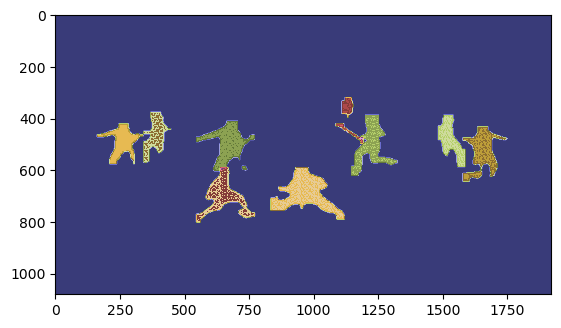

In [17]:
empty_img = np.zeros(segmentations[0].shape)

for idx, img in enumerate(segmentations):
    empty_img += (img*(idx+5))

plt.imshow(empty_img, cmap = "tab20b")

# 2. Collect Optical Flow Values for Frame

In [15]:
out_optical = output_optical(fls_to_analyze)
wanted_optical = process_optical_flow([out_optical[25]])

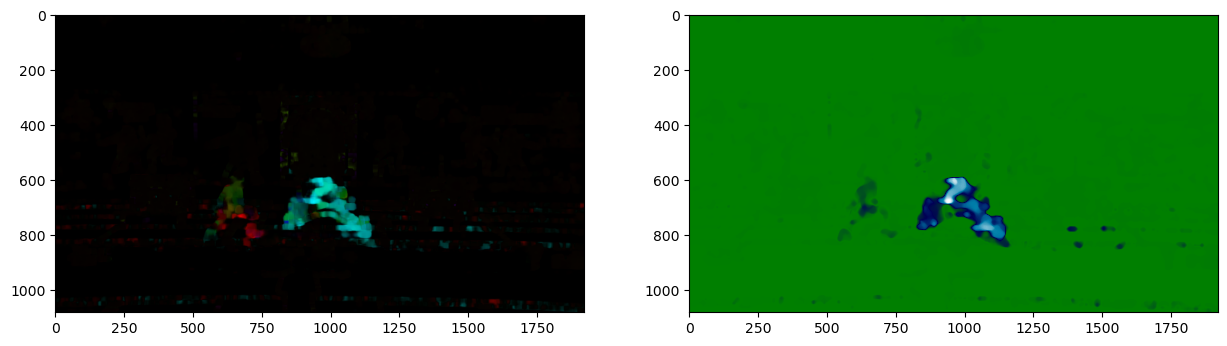

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].imshow(out_optical[25])
ax[1].imshow(wanted_optical[0], cmap = "ocean")

In [39]:
a, b = return_correct_segmentation_map(wanted_optical, segmentations)

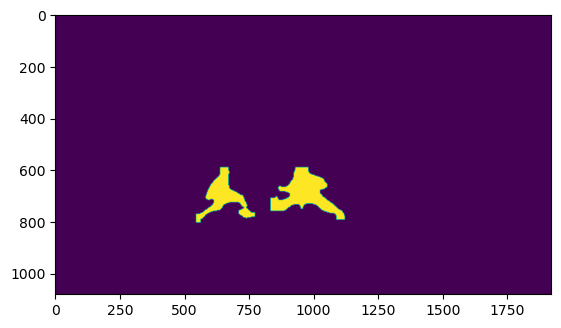

In [40]:
plt.imshow(a + b)

In [56]:
lst_of_segments = segment_out_images([out[25].orig_img], [[a, b]])

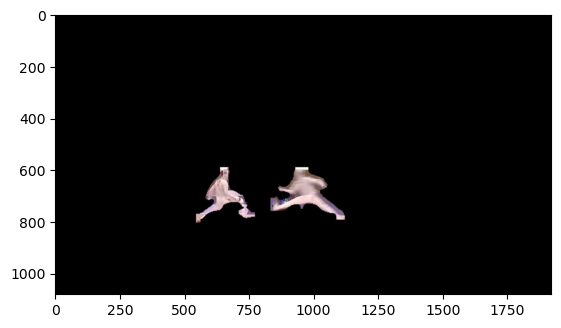

In [59]:
plt.imshow(lst_of_segments[0][0] + lst_of_segments[0][1])

In [78]:
kpts_pose = md_pose(lst_of_segments[0][1])


0: 384x640 1 person, 202.7ms
Speed: 6.2ms preprocess, 202.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


In [80]:
kpts_pose[0].show()

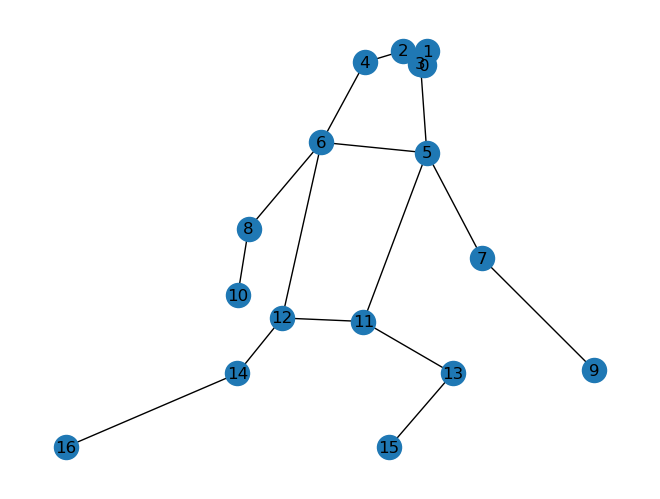

In [ ]:
skeleton = [
    (0, 1), (1, 3),
    (3, 5), (1, 2),
    (0, 2), (2, 4),
    (4, 6),
    (5, 7), (7, 9),  # left arm
    (6, 8), (8, 10), # right arm
    (5, 6),          # shoulders
    (11, 12),        # hips
    (5, 11), (6, 12),# torso
    (11, 13), (13, 15), # left leg
    (12, 14), (14, 16)  # right leg
]

pose_coords = kpts_pose[0].keypoints.xyn.numpy()[0]

pose_new = {a:(b[0], 1-b[1]) for (a, b) in enumerate(pose_coords)}

gph = nx.Graph(skeleton)
gph_node_label = {a:a for a in gph.nodes}
nx.draw(gph, labels = gph_node_label, pos=pose_new)

# Additional Notes:

1. We can apply analysis to every frame in an image.

2. We can save data in a yaml file (keypoints, confidence keypoints) in graph neural network.

3. We can load data in dataloader for torch geometric dataloader.

4. Next step is to train GCN with collected information.